In [2]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile
from pydub import AudioSegment
from IPython.display import Audio, display
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer

import random
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
def spectrogramify(instance, phase, nperseg=1000):
    # instance: record name
    # phase: train, val, or test
    source = "nsynth-" + str(phase) + "/audio/" + str(instance) + ".wav"
    sample_rate, samples = wavfile.read(source)
    frequencies, times, spectrogram = signal.stft(samples, fs=sample_rate, nperseg=nperseg)

    return sample_rate, frequencies, times, spectrogram
def show_spectro(times, frequencies, spectrogram):
    f = plt.figure()
    f.set_figwidth(5)
    f.set_figheight(3)

    plt.pcolormesh(times, frequencies, np.abs(spectrogram))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim([0, 2000])
    plt.show()
    
def spectro_to_wav(spectrogram, sample_rate = 16000):
    _, gen = signal.istft(spectrogram, sample_rate)
    wavfile.write("output.wav", sample_rate, gen.astype(np.int16))
    return True

def spectro_to_audio(spectrogram, sample_rate = 16000):
    spectro_to_wav(spectrogram, sample_rate)
    wav = "output.wav"
    display(Audio(wav, autoplay=True))
    
def decompose_spect(y):
    y_real = []
    y_imag = []
    for i in range(len(y)):
        y_real.append(y[i].real)
        y_imag.append(y[i].imag)
    return np.array(y_real), np.array(y_imag)

def recompose_spect(y_real, y_imag):
    y = 1j*y_imag
    y += y_real
    return np.array(y)
     


In [5]:
%cd "/content/drive/MyDrive/Colab Notebooks/Projects/"

/content/drive/MyDrive/Colab Notebooks/Projects


In [6]:
df = pd.read_json(f"nsynth-test/examples.json", orient='index')
df.head(5)

,qualities,pitch,note,instrument_source_str,velocity,instrument_str,instrument,sample_rate,qualities_str,instrument_source,note_str,instrument_family,instrument_family_str
bass_synthetic_068-049-025,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",49,217499,synthetic,25,bass_synthetic_068,656,16000,[dark],2,bass_synthetic_068-049-025,0,bass
keyboard_electronic_001-021-127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21,299359,electronic,127,keyboard_electronic_001,40,16000,[],1,keyboard_electronic_001-021-127,4,keyboard
guitar_acoustic_010-066-100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",66,72288,acoustic,100,guitar_acoustic_010,219,16000,[],0,guitar_acoustic_010-066-100,3,guitar
reed_acoustic_037-068-127,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",68,22259,acoustic,127,reed_acoustic_037,387,16000,[reverb],0,reed_acoustic_037-068-127,7,reed
flute_acoustic_002-077-100,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",77,72001,acoustic,100,flute_acoustic_002,86,16000,[reverb],0,flute_acoustic_002-077-100,2,flute


Text(0.5, 0, 'type of instrument noise')

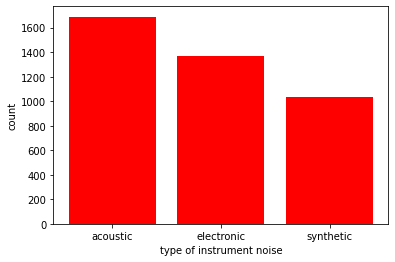

In [7]:
df.instrument_source_str.value_counts()
x = df.instrument_source_str.value_counts()
plt.bar(x.index, x.values, color='r')
plt.ylabel('count')
plt.xlabel('type of instrument noise')

In [8]:
d_ = {'synthetic':0, 'electronic':1, 'acoustic':2}
d = {v: k for k, v in d_.items()} 
d

{0: 'synthetic', 1: 'electronic', 2: 'acoustic'}

In [9]:
df.instrument_source_str = df.instrument_source_str.replace({'synthetic':0, 'electronic':1, 'acoustic':2})
df

,qualities,pitch,note,instrument_source_str,velocity,instrument_str,instrument,sample_rate,qualities_str,instrument_source,note_str,instrument_family,instrument_family_str
bass_synthetic_068-049-025,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",49,217499,0,25,bass_synthetic_068,656,16000,[dark],2,bass_synthetic_068-049-025,0,bass
keyboard_electronic_001-021-127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21,299359,1,127,keyboard_electronic_001,40,16000,[],1,keyboard_electronic_001-021-127,4,keyboard
guitar_acoustic_010-066-100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",66,72288,2,100,guitar_acoustic_010,219,16000,[],0,guitar_acoustic_010-066-100,3,guitar
reed_acoustic_037-068-127,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",68,22259,2,127,reed_acoustic_037,387,16000,[reverb],0,reed_acoustic_037-068-127,7,reed
flute_acoustic_002-077-100,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",77,72001,2,100,flute_acoustic_002,86,16000,[reverb],0,flute_acoustic_002-077-100,2,flute
...,...,...,...,...,...,...,...,...,...,...,...,...,...
brass_acoustic_006-088-075,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",88,35344,2,75,brass_acoustic_006,43,16000,[reverb],0,brass_acoustic_006-088-075,1,brass
organ_electronic_028-044-100,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",44,187148,1,100,organ_electronic_028,440,16000,[dark],1,organ_electronic_028-044-100,6,organ
string_acoustic_071-027-127,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",27,114253,2,127,string_acoustic_071,609,16000,"[long_release, reverb]",0,string_acoustic_071-027-127,8,string
string_acoustic_057-063-127,"[1, 0, 0, 0, 0, 0, 1, 0, 1, 0]",63,58959,2,127,string_acoustic_057,450,16000,"[bright, nonlinear_env, reverb]",0,string_acoustic_057-063-127,8,string


In [10]:
c = df.columns
c = [x for x in c if x != 'instrument_source_str']
c

['qualities',
 'pitch',
 'note',
 'velocity',
 'instrument_str',
 'instrument',
 'sample_rate',
 'qualities_str',
 'instrument_source',
 'note_str',
 'instrument_family',
 'instrument_family_str']

In [11]:
data = df.drop(columns=c)
data['name'] = data.index
data = data.reset_index(drop=True)

In [12]:
data.head(5)

,instrument_source_str,name
0,0,bass_synthetic_068-049-025
1,1,keyboard_electronic_001-021-127
2,2,guitar_acoustic_010-066-100
3,2,reed_acoustic_037-068-127
4,2,flute_acoustic_002-077-100


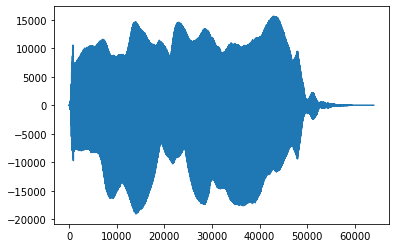

In [45]:
#looking at the foiour transform
instance = 'reed_acoustic_037-068-127'
source = "nsynth-test/audio/" + str(instance) + ".wav"
sample_rate, samples = wavfile.read(source)
plt.plot(samples)

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


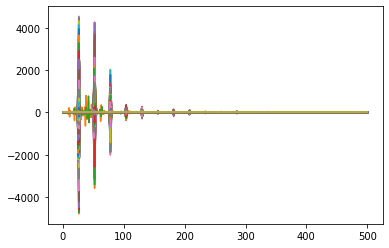

In [46]:
frequencies, times, spectrogram = signal.stft(samples, fs=sample_rate, nperseg=1000)
plt.plot(spectrogram)

In [ ]:
spec = np.real(spectrogram)
plt.plot(spec)

In [15]:
vector = data[data['name'] == instance]
lv = list(vector.values)
a = np.array(lv[0][:-1])
y = np.array(list(lv[0][:-1]))

In [16]:
vector.values[0][0]

1

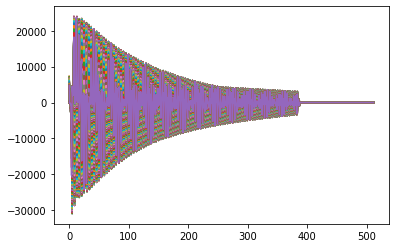

In [17]:
wav_og = samples.reshape(512,125)
plt.plot(wav_og)

## Lets make a dataset loader


In [25]:
# Lets build a dataloader

class WavOriginalDataset(Dataset):
    def __init__(self):
        self.imgs_path = "nsynth-test/audio/" 
        file_list_data = glob.glob(self.imgs_path + "*")
        self.vector_path = ""
        #print(file_list_data)
        self.data = []
        for file_path in file_list_data:
            file_name = file_path.split("/")[-1].split(".")[0]
            vector = data[data['name'] == file_name]
            y = vector.values[0][0]
            img_path = file_name
            self.data.append([img_path, y])
        random.shuffle(self.data)
        self.img_dim = (501, 129)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        path, y = self.data[idx]
        source = "nsynth-test/audio/" + str(path) + ".wav"
        sample_rate, samples = wavfile.read(source)
        samples = samples.reshape(512,125)
        img_tensor = torch.from_numpy(samples)
        y = torch.tensor(y)
        return  img_tensor, y

In [13]:
# Lets build a dataloader

class FourierDataset(Dataset):
    def __init__(self):
        self.imgs_path = "nsynth-test/audio/" 
        file_list_data = glob.glob(self.imgs_path + "*")
        self.vector_path = ""
        #print(file_list_data)
        self.data = []
        for file_path in file_list_data:
            file_name = file_path.split("/")[-1].split(".")[0]
            vector = data[data['name'] == file_name]
            y = vector.values[0][0]
            img_path = file_name
            self.data.append([img_path, y])
        random.shuffle(self.data)
        self.img_dim = (501, 129)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        path, y = self.data[idx]
        source = "nsynth-test/audio/" + str(path) + ".wav"
        sample_rate, samples = wavfile.read(source)
        frequencies, times, spectrogram = signal.stft(samples, fs=sample_rate, nperseg=1000)
        spectrogram = np.real(spectrogram)
        spec_fourier = torch.from_numpy(spectrogram)
        #samples = spec_fourier.reshape(501,129)
        #img_tensor = torch.from_numpy(samples)
        return  spec_fourier, y

In [14]:
#Fourier
dataset = FourierDataset()
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
dataset.__len__()



4096

In [26]:
dataset = WavOriginalDataset()
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
dataset.__len__()



4096

Text(0.5, 1.0, 'fourier transform')

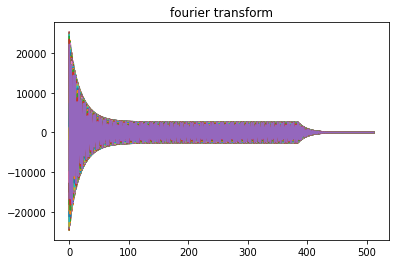

In [27]:
abc = dataset.__getitem__(0)
plt.plot(abc[0])
plt.title('fourier transform')

In [25]:
abc[0].sum()

tensor(-17337.2676+0.0156j)

In [28]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [29]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [31]:
dataiter = iter(train_loader)
spec, y = next(dataiter)

In [32]:
y[0]

tensor(2)

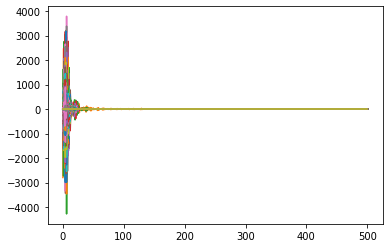

In [33]:
plt.plot(spec[0])

## Model VGG-19

In [47]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        #24576 512,125
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(24576, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
#507904

device(type='cuda')

In [49]:
num_classes = 3
num_epochs = 15
learning_rate = 0.005
model = None
model = VGG16(num_classes).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Train the model
total_step = len(train_loader)


In [50]:

total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        labels = labels.type(torch.LongTensor)
        images = images.float().unsqueeze(1)
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        #print(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            labels = labels.type(torch.LongTensor)
            images = images.float().unsqueeze(1)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

# from google.colab import files
# torch.save(model.state_dict(), 'model_vgg.pth')
# files.download('model_vgg.pth')


Epoch [1/15], Step [103/103], Loss: 0.9771
Accuracy of the network on the 5000 validation images: 52.19512195121951 %
Epoch [2/15], Step [103/103], Loss: 0.5154
Accuracy of the network on the 5000 validation images: 60.97560975609756 %
Epoch [3/15], Step [103/103], Loss: 0.5234
Accuracy of the network on the 5000 validation images: 63.65853658536585 %
Epoch [4/15], Step [103/103], Loss: 1.2411
Accuracy of the network on the 5000 validation images: 68.78048780487805 %
Epoch [5/15], Step [103/103], Loss: 0.5200
Accuracy of the network on the 5000 validation images: 68.65853658536585 %
Epoch [6/15], Step [103/103], Loss: 0.3209
Accuracy of the network on the 5000 validation images: 75.1219512195122 %
Epoch [7/15], Step [103/103], Loss: 0.1318
Accuracy of the network on the 5000 validation images: 77.8048780487805 %
Epoch [8/15], Step [103/103], Loss: 0.3146
Accuracy of the network on the 5000 validation images: 78.90243902439025 %
Epoch [9/15], Step [103/103], Loss: 0.5722
Accuracy of the

In [23]:
from google.colab import files
torch.save(model.state_dict(), 'model_vgg_fourier.pth')
files.download('model_vgg_fourier.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
wave = VGG16(3).to(device)
fourier = VGG16(3).to(device)

wave.load_state_dict(torch.load('model_vgg_16_5.pth'))

fourier.load_state_dict(torch.load('model_vgg_fourier.pth'))

RuntimeError: ignored